## Import Packages

In [1]:
from datetime import date
import logging
import numpy as np
import os
import pandas as pd
import sys
import swifter
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings


from src.local.etl_helper import Extract
from src.local.feature_engineering_helper import MutualInformation,XgbcFeatureImportance
from src.local.preprocess_helper import CreateTargetLabel, ColumnPreprocess


sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

Settings for jupyter notebook

In [2]:
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable toc2/main

## Read Data

Description for each column

In [3]:
# big5 encoding to avoid unidecodeerror
path = '/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/data'
column_description = pd.read_csv(os.path.join(path, 'column_description.csv'), encoding = "big5")
column_description

,Column,Description
0,User_id,用戶 ID
1,Merchant_id,商家 ID
2,Coupon_id,優惠券 ID (null 代表無優惠券消費)
3,Discount_rate,"優惠券折價：[0,1] 代表折扣率；x:y 代表滿 x 減 y 元"
4,Distance,"用戶經常活動地點離商家最近距離 (x * 500 公尺), 0 表示低於 500 公尺, 1..."
5,Date_received,優惠券取得時間
6,Date,購買商品時間 (如果 Date is null & Coupon_id is not nul...


[2021-05-23 22:06:25,802] - p26912 - {/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/src/local/etl_helper.py:28} - extract - INFO - shape: (1160742, 7)
[2021-05-23 22:06:25,805] - p26912 - {/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/src/local/etl_helper.py:29} - extract - INFO - columns: Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160742 entries, 0 to 1160741
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   User_id        1160742 non-null  int64  
 1   Merchant_id    1160742 non-null  int64  
 2   Coupon_id      746969 non-null   float64
 3   Discount_rate  746969 non-null   object 
 4   Distance       1090916 non-null  float64
 5   Date_received  746969 non-null   float64
 6   Date           456709 non-null   float64
dtypes: float

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN


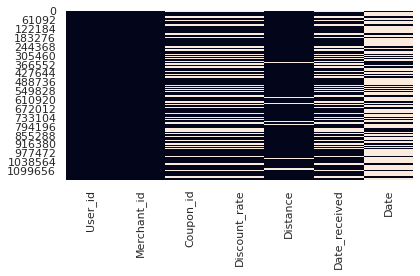

In [4]:
df_train = Extract().read(
    '/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/data/train_offline.csv')
df_train.head(3)

[2021-05-23 22:06:36,818] - p26912 - {/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/src/local/etl_helper.py:28} - extract - INFO - shape: (594142, 9)
[2021-05-23 22:06:36,820] - p26912 - {/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/src/local/etl_helper.py:29} - extract - INFO - columns: Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date', 'label', 'to_testset'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594142 entries, 0 to 594141
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   User_id        594142 non-null  int64  
 1   Merchant_id    594142 non-null  int64  
 2   Coupon_id      306313 non-null  float64
 3   Discount_rate  306313 non-null  object 
 4   Distance       557965 non-null  float64
 5   Date_received  306313 non-null  float64
 6   Date           320275 non-null  float64
 7

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,to_testset
0,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN,0,True
1,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,0,True
2,1439408,2632,NaN,NaN,0.0,NaN,20160516.0,-1,True


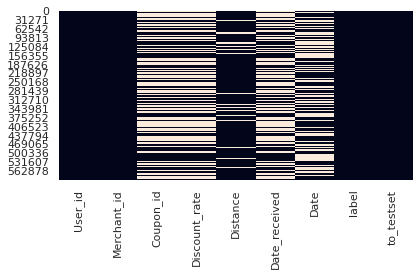

In [5]:
df_test = Extract().read(
    '/home/js/py_ds_nas/ds_competitions/kaggle/using-coupon-prediction/data/test_offline.csv')
df_test.head(3)

## Preprocessing - Basic preprocess for each column

In [6]:
df_train["label"] = df_train.swifter.apply(CreateTargetLabel.label, axis=1)
df_train["label"].value_counts()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

In [30]:
df_train.isnull().sum()

User_id                    0
Merchant_id                0
Coupon_id                  0
Discount_rate              0
Distance                   0
Date_received              0
Date                  704033
label                      0
discount_rate              0
discount_man               0
discount_jian              0
discount_type              0
weekday                    0
is_weekend                 0
weekday_1                  0
weekday_2                  0
weekday_3                  0
weekday_4                  0
weekday_5                  0
weekday_6                  0
weekday_7                  0
couponNumPerUser_x         0
couponNumPerUser_y         0
couponNumPerUser_x         0
couponNumPerUser_y         0
dtype: int64

In [7]:
# 去除掉 "buy without coupon ==> -1"
## Creat target label 
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
df_train = df_train[~df_train['label'] < 0]

In [8]:
df_train.shape

(746969, 8)

In [9]:
df_train = ColumnPreprocess().process_data(df=df_train)
df_test = ColumnPreprocess().process_data(df=df_test)

Pandas Apply:   0%|          | 0/746969 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/746969 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/746969 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/746969 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/746969 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/594142 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/594142 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/594142 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/594142 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/594142 [00:00<?, ?it/s]

## EDA

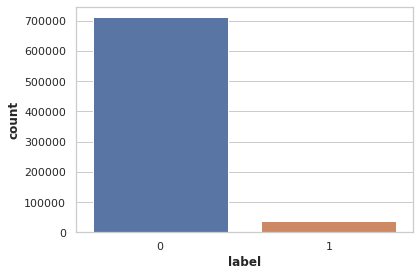

In [10]:
ax = sns.countplot(x="label", data=df_train)

This is an imbalanced dataset

Mutual Information (MI)

MI score - value meaning

--

infinity

2: above is unusual

0: independent

In [11]:
X = df_train.dropna(how='any')
X = X.loc[:, ~X.columns.isin(['Date', 'Discount_rate', 'Date_received', 'weekday', 'discount_man', 
                              'discount_jian'])]
y = X.pop('label')

mi_scores = MutualInformation().make_mi_scores(X, y)
print('mi_scores:', mi_scores)

mi_scores: User_id          4.386548
Coupon_id        0.594887
Merchant_id      0.417610
discount_rate    0.022891
discount_type    0.016721
weekday_3        0.009128
is_weekend       0.007965
weekday_5        0.007248
weekday_7        0.007122
weekday_6        0.005770
weekday_2        0.005058
weekday_4        0.003795
weekday_1        0.003522
Distance         0.000000
Name: MI Scores, dtype: float64


In [12]:
from sklearn.model_selection import train_test_split

def as_type_int(df, col_list):
    for col in col_list:
        df[col] = df[col].astype(float)
    return df

X = as_type_int(X, ['User_id', 'Merchant_id', 'Coupon_id'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

In [13]:
X_train.head()

,User_id,Merchant_id,Coupon_id,Distance,discount_rate,discount_type,is_weekend,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
300636,2222829.0,5341.0,11539.0,0.0,0.833333,1,0,0,0,0,0,0,1,0
1076466,4937190.0,3381.0,9776.0,2.0,0.500000,1,0,0,0,0,0,1,0,0
617113,3087229.0,6189.0,6119.0,0.0,0.833333,1,0,1,0,0,0,0,0,0
251184,7057358.0,5907.0,7981.0,5.0,0.833333,1,0,0,1,0,0,0,0,0
782399,1053885.0,8775.0,466.0,1.0,0.500000,1,0,0,0,0,0,0,0,1


In [14]:
def discount_level(row, col):
    if 0.9 <= float(row[col]):
        return 0
    elif 0.85 <= float(row[col]) < 0.9:
        return 1
    elif 0.7 <= float(row[col]) < 0.85:
        return 2
    elif 0.6 <= float(row[col]) < 0.7:
        return 3
    elif 0.5 <= float(row[col]) < 0.6:
        return 4
    else:
        return 5
X['discount_level'] = X.swifter.apply(lambda x: discount_level(x, "discount_rate"), axis=1)
X.head()

,User_id,Merchant_id,Coupon_id,Distance,discount_rate,discount_type,is_weekend,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,discount_level
18,2881376.0,8390.0,7531.0,0.0,0.750000,1,0,1,0,0,0,0,0,0,2
43,114747.0,5341.0,111.0,0.0,0.833333,1,0,0,0,1,0,0,0,0,2
44,114747.0,5341.0,111.0,0.0,0.833333,1,0,0,0,0,0,0,0,1,2
45,114747.0,5341.0,7751.0,0.0,0.800000,1,0,0,0,1,0,0,0,0,2
49,114747.0,2454.0,8088.0,0.0,0.750000,1,0,0,0,0,1,0,0,0,2


In [25]:
# Change the default stacking
import plotly.express as px


fig = px.histogram(X, x="discount_type", y=y,
             color='discount_level', barmode='group', title="discont type - 0: 折扣率; 1: 滿 x 減 y 元")
fig.show()

# # seaborn version
# sns.catplot(y=y, hue="discount_level", kind="count",
#             palette="pastel", edgecolor=".6",
#             data=X)

In [16]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

[22:12:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
print('The accuracy of eXtreme Gradient Boosting Classifier on testing set:', xgbc.score(X_test, y_test))

The accuracy of eXtreme Gradient Boosting Classifier on testing set: 0.8505682876839947


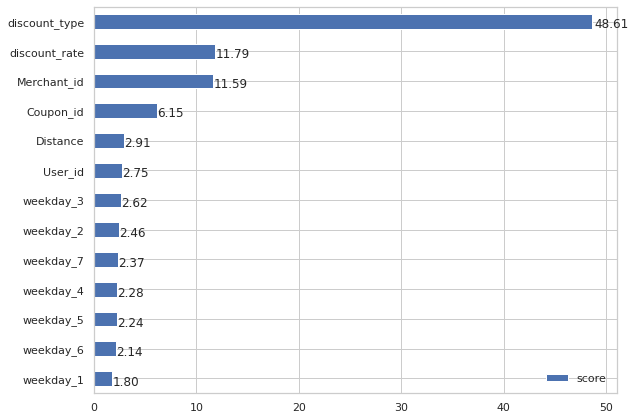

In [18]:
XgbcFeatureImportance().plot_feature_importance(xgbc_model=xgbc, importance_type='gain')

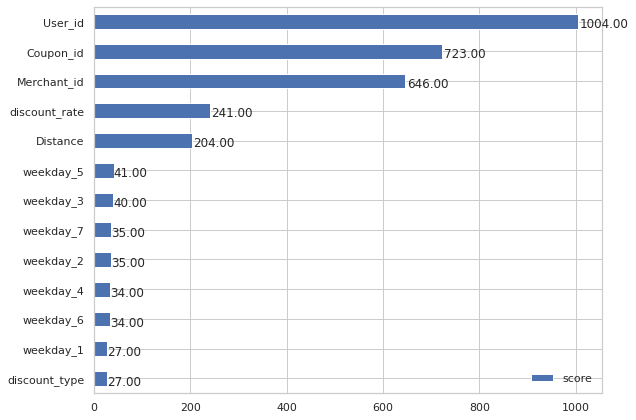

In [19]:
XgbcFeatureImportance().plot_feature_importance(xgbc_model=xgbc, importance_type='weight')

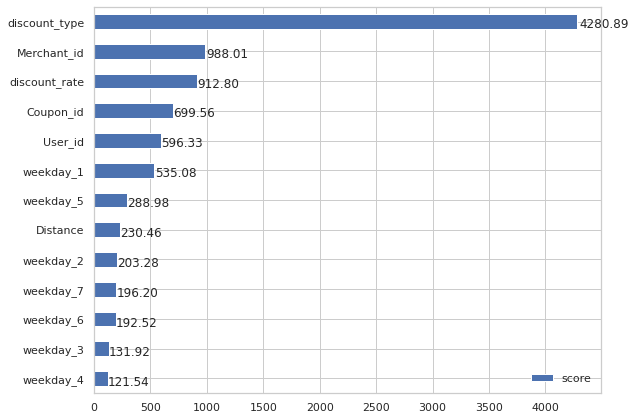

In [20]:
XgbcFeatureImportance().plot_feature_importance(xgbc_model=xgbc, importance_type='cover')

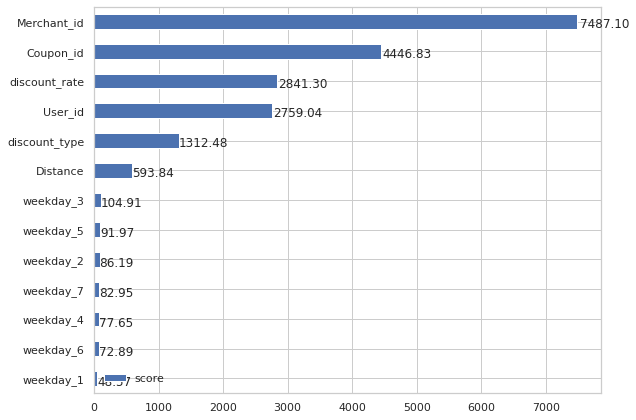

In [21]:
XgbcFeatureImportance().plot_feature_importance(xgbc_model=xgbc, importance_type='total_gain')

In [22]:
# from xgboost import plot_importance
# import matplotlib.pyplot as plt
# fig, (ax) = plt.subplots(2, 2, figsize = (40, 24))

# feature_important = xgbc.get_booster().get_score(importance_type='gain')

# keys = list(feature_important.keys())
# values = list(feature_important.values())
# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=True)

# ax[0][0] = data.plot(kind='barh', ax = ax[0][0])
# # show values
# for p in ax[0][0].patches:
#     ax[0][0].annotate("{:.2f}".format(float(p.get_width())), (p.get_width() * 1.005, p.get_y() * 1.005))
# ax[0][0].set_title("gain", size = 15, pad = 20)
# ax[0][0].set_xlabel('feature name',fontsize=14)
# ax[0][0].set_ylabel('gain',fontsize=14)   
    
    
# plt.style.use('ggplot')

# sns.set(font_scale=3) # font size
# sns.set(style="darkgrid")

# # x-axis 字體方向
# for ax in fig.axes:
#     plt.sca(ax)
#     plt.xticks(rotation=0)
        
# # plt.subplots_adjust(wspace = 0.15, hspace = 0.05)
# # 總標題
# fig.suptitle("Status", fontsize=30)
# plt.text(x=0.5, y=0.85, s= "-- Frequency by Market", fontsize=24, ha="center", transform=fig.transFigure)

# plt.subplots_adjust(top=0.75)
# plt.show()

## Feature Engineering

In [23]:
# 每人not unique商家數（購物趟數）
df_train_merchantNumPerUser = (df_train.groupby('User_id')['Merchant_id'].count())\
  .to_frame()\
  .rename(columns = {"Merchant_id" : "merchantNumPerUser"})\
  .reset_index()
pd.merge(df_train, df_train_merchantNumPerUser, how = "left", on = ["User_id"])

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_rate,discount_man,...,weekday,is_weekend,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,merchantNumPerUser
0,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,0.950000,20,...,3,0,0,0,1,0,0,0,0,2
1,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,0.950000,20,...,6,0,0,0,0,0,0,1,0,2
2,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,0.900000,200,...,5,0,0,0,0,0,1,0,0,1
3,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,0.900000,200,...,5,0,0,0,0,0,1,0,0,1
4,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,0,0.500000,10,...,5,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746964,3795296,5341,111.0,30:5,0.0,20160129.0,NaN,0,0.833333,30,...,5,0,0,0,0,0,1,0,0,1
746965,188086,6568,4723.0,30:1,0.0,20160415.0,NaN,0,0.966667,30,...,5,0,0,0,0,0,1,0,0,1
746966,212662,2934,5686.0,30:5,2.0,20160321.0,20160330.0,1,0.833333,30,...,1,0,1,0,0,0,0,0,0,3
746967,212662,3532,5267.0,30:5,1.0,20160322.0,NaN,0,0.833333,30,...,2,0,0,1,0,0,0,0,0,3


In [34]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# --- train ---

# 每人優惠卷數
train_couponNumPerUser = (df_train.groupby('User_id')['Coupon_id'].count()).to_frame().rename(columns = {"Coupon_id" : "couponNumPerUser"}).reset_index()
df_train = pd.merge(df_train, train_couponNumPerUser, how = "left", on = ["User_id"])

# 折扣率不優於七折的優惠卷數量 (according to EDA)
train_goodDiscountCouNumPerUser = (df_train.groupby('User_id').parallel_apply(lambda x: x[x['discount_rate'] > 0.7]['Coupon_id'].count())).to_frame().rename(columns = {0 : "goodDiscountCouNumPerUser"}).reset_index()
df_train = pd.merge(df_train, train_goodDiscountCouNumPerUser, how = "left", on = ["User_id"])


In [ ]:
# --- train ---

# 每人not unique商家數（購物趟數）
train_merchantNumPerUser = (df_train.groupby('User_id')['Merchant_id'].count()).to_frame().rename(columns = {"Merchant_id" : "merchantNumPerUser"}).reset_index()
df_train = pd.merge(df_train, train_merchantNumPerUser, how = "left", on = ["User_id"])

# 每人 平均購物距離
train_distPerUser = (df_train.groupby('User_id')['Distance'].mean()).to_frame().rename(columns = {"Distance" : "distPerUser"}).reset_index()
df_train = pd.merge(df_train, train_distPerUser, how = "left", on = ["User_id"])